**Table of contents**
1. Abstract
2. Data preprocessing and analyzing
   - Data cleaning
   - Data reduction
   - Data normalization
   - One hot encoding
3. Model training and optimization of hyperparameters using by Optuna
    - KNN
    - Decision Tree
    - Bagging
    - AdaBoost
    - XGBoost
4. Summary

# Abstract
The aim of the thesis is to choose and optimize a machine learning algorithm to perform classification of "The adult dataset" into two classes. Classificaion task is to determine whether a person makes over 50K a year.

# Data Preprocessing and analyzing

In [60]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

import xgboost

import optuna

In [2]:
colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
            'marital_status', 'occupation', 'relationship', 'race', 
            'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 
            'native_country', 'wage_class']

data = pd.read_csv("adult/adult.data", skipinitialspace = True, names = colnames)
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
data["wage_class"] = data["wage_class"].replace({">50K" : 1, "<=50K" : 0})

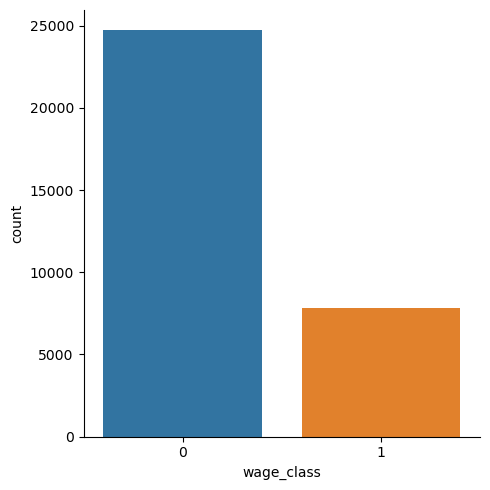

In [5]:
wage_class_size = data.groupby(['wage_class']).size().to_frame("size").reset_index()
ax = sn.catplot(data = data, x="wage_class", kind="count", legend=True)
plt.show()

## Data cleaning

In [6]:
pd.crosstab(data.education, data.education_num)

education_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,933,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1175,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,433,0,0,0,0,0,0,0,0
1st-4th,0,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,333,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,646,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,514,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1067,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1382,0,0,0,0,0


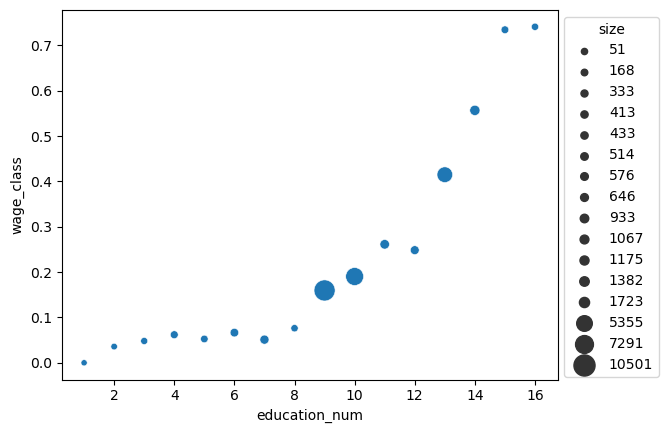

In [7]:
wage_vs_edu = data.groupby('education_num')["wage_class"].mean()

plot = sn.scatterplot(x = wage_vs_edu.index, y = wage_vs_edu, size = data.groupby('education_num').size(), sizes=(20, 230), legend = 'full')
sn.move_legend(plot, "upper left", bbox_to_anchor=(1, 1), title = 'size')
plt.show()

Grouping education into classes:
- class 1 - 1th-12th
- class 2 - HS-grad and Some-college
- class 3 - Assoc-acdm and Assoc-voc
- class 4 - Bachelors
- class 5 - Masters
- class 6 - Prof-school and Doctorate

In [8]:
data['education_num'] = data['education_num'].replace(np.arange(1, 17), [1]*8 + [2, 2, 3, 3, 4, 5, 6, 6])

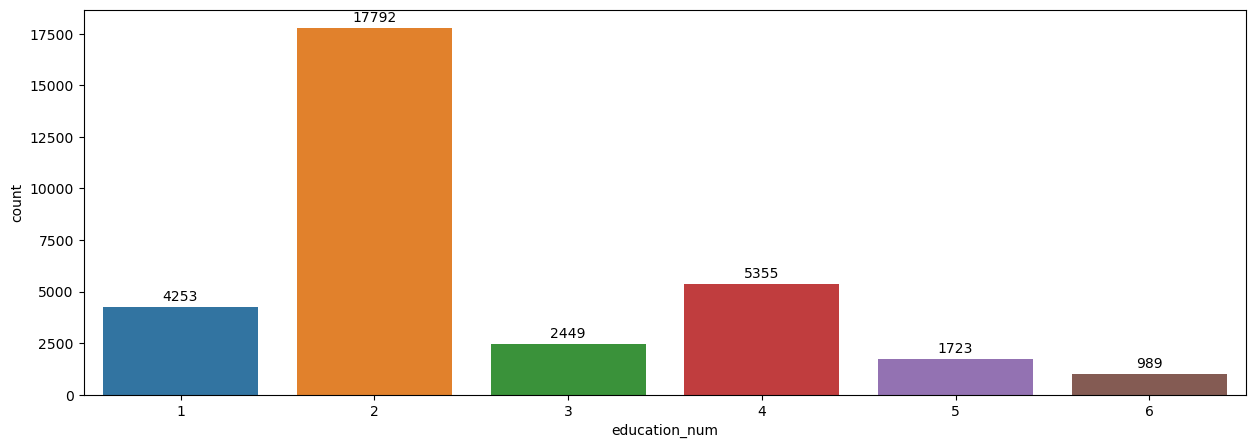

In [9]:
plt.figure(figsize = (15, 5))
ax = sn.countplot(x = "education_num", data = data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 300,
            s = height,
            ha = "center") 
plt.show()

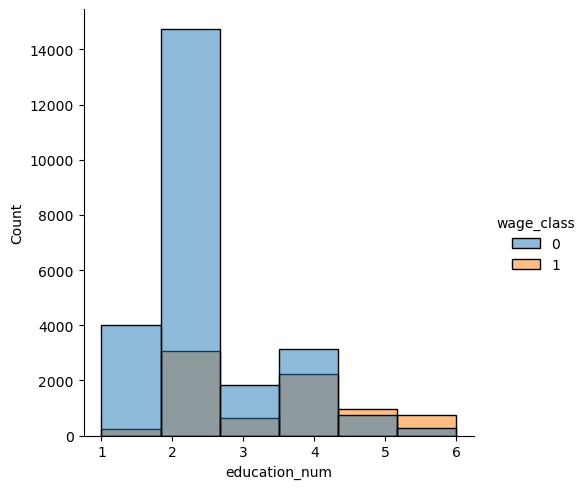

In [10]:
sn.displot(data = data, x = 'education_num', bins = 6, hue = 'wage_class')
plt.show()

In [11]:
data.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

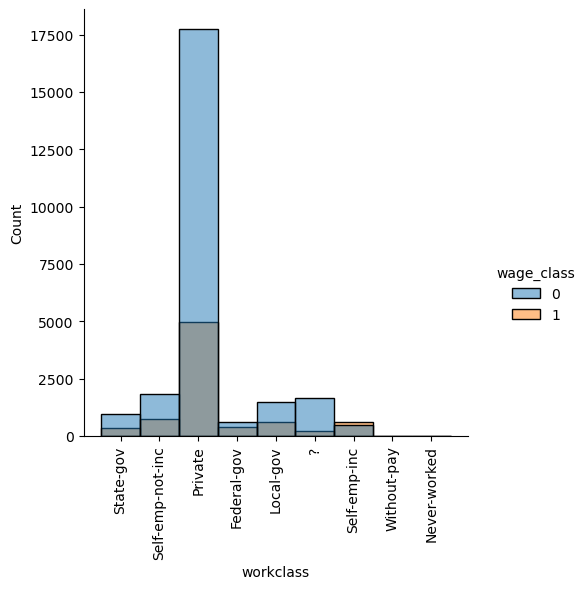

In [12]:
sn.displot(data = data, x = 'workclass', bins = 9, hue = 'wage_class')
plt.xticks(rotation = 90)
plt.show()

<Figure size 480x480 with 0 Axes>

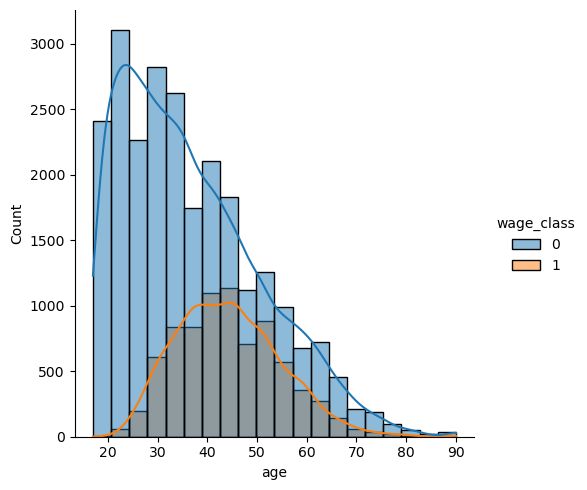

In [13]:
plt.figure(figsize = (6, 6), dpi = 80)
sn.displot(data = data, x = 'age', bins = 20, kde = True, hue = 'wage_class')
plt.show()

Observation:
- People who earn more than 50K tend to be between the ages of 35 and 55.
- Most people with incomes under 50K are between the ages of 17 and 35.

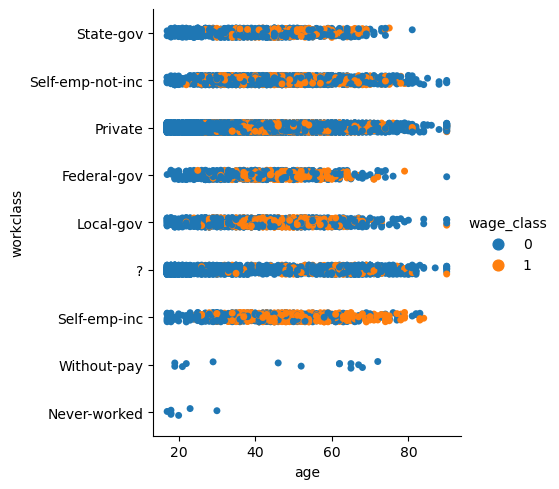

In [14]:
sn.catplot(data = data, x="age", y="workclass", hue="wage_class")
plt.show()

In [15]:
print(data.marital_status.value_counts())
data.groupby('marital_status')["wage_class"].mean()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64


marital_status
Divorced                 0.104209
Married-AF-spouse        0.434783
Married-civ-spouse       0.446848
Married-spouse-absent    0.081340
Never-married            0.045961
Separated                0.064390
Widowed                  0.085599
Name: wage_class, dtype: float64

In [16]:
data["marital_status"] = data.marital_status.replace(["Married-AF-spouse", "Married-civ-spouse"], "Married-spouse")
data["marital_status"] = data.marital_status.replace(["Widowed"], "Married-spouse-absent")

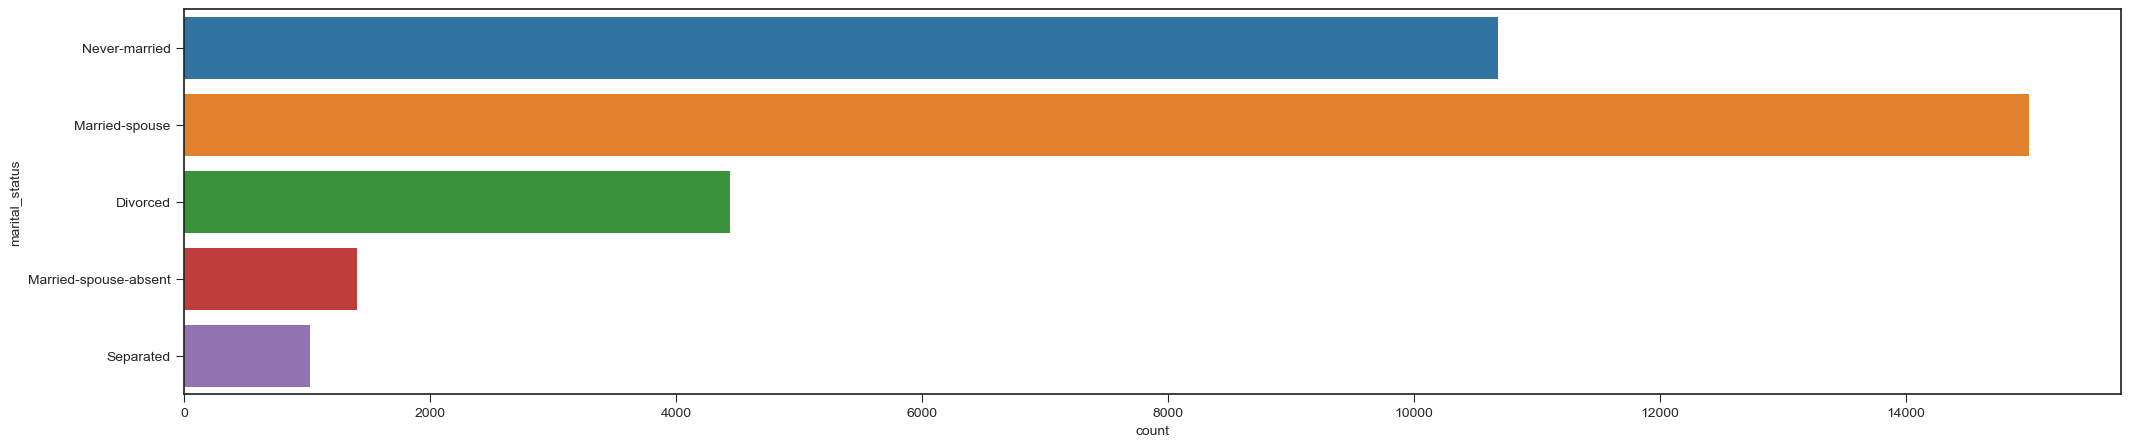

In [17]:
fig = plt.figure(figsize = (25,5))
plt.style.use('seaborn-ticks')
sn.countplot(y = "marital_status", data = data)
plt.show()

In [18]:
print(data["sex"].value_counts())
data["sex"] = data["sex"].replace({"Male": 0, "Female": 1})

Male      21790
Female    10771
Name: sex, dtype: int64


In [19]:
data["native_country"].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

In [20]:
data["is_native_us"] = (data["native_country"] == "United-States").astype(int)
data = data.drop(["native_country"], axis=1)

In [21]:
data.race.value_counts()

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

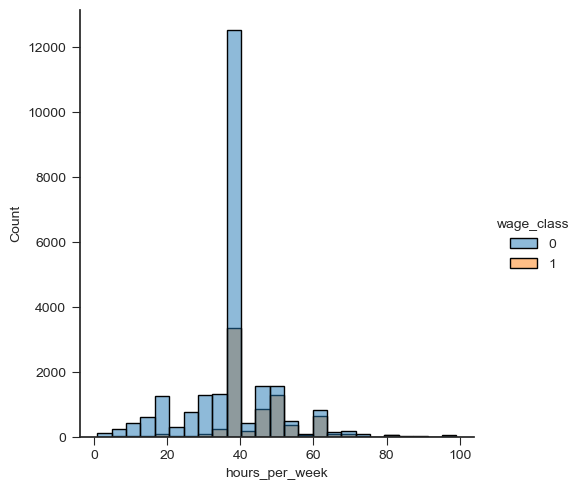

In [22]:
sn.displot(data = data, x = 'hours_per_week', bins = 25, hue = 'wage_class')
plt.show()

In [23]:
data['capital'] = data.capital_gain - data.capital_loss

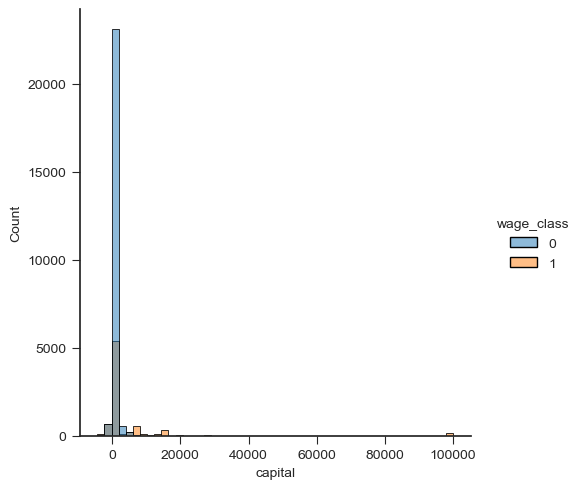

In [24]:
sn.displot(data = data, x = 'capital', bins = 50, hue = 'wage_class')
plt.show()

## Data reduction
Dropping the variables not to be used for modeling

In [25]:
data = data.drop(["fnlwgt", "education", "relationship", "capital_loss", "capital_gain"], axis=1)
data.head()

,age,workclass,education_num,marital_status,occupation,race,sex,hours_per_week,wage_class,is_native_us,capital
0,39,State-gov,4,Never-married,Adm-clerical,White,0,40,0,1,2174
1,50,Self-emp-not-inc,4,Married-spouse,Exec-managerial,White,0,13,0,1,0
2,38,Private,2,Divorced,Handlers-cleaners,White,0,40,0,1,0
3,53,Private,1,Married-spouse,Handlers-cleaners,Black,0,40,0,1,0
4,28,Private,4,Married-spouse,Prof-specialty,Black,1,40,0,0,0


## One hot encoding

In [26]:
y = data.wage_class
X = data.drop(["wage_class"], axis=1)

X_ohe = pd.get_dummies(X, drop_first=True)
X_ohe.head(2)

,age,education_num,sex,hours_per_week,is_native_us,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital_status_Married-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,4,0,40,1,2174,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,50,4,0,13,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Train-test split and standarization

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.15, random_state=123)

scaler = StandardScaler()

X_train[
    ["age", "education_num", "capital", "hours_per_week"]
] = scaler.fit_transform(
    X_train[["age", "education_num", "capital","hours_per_week"]]
)

X_test[
    ["age", "education_num", "capital", "hours_per_week"]
] = scaler.fit_transform(
    X_test[["age", "education_num", "capital","hours_per_week"]]
)

# Modeling

## KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

scores = []
k_list = np.arange(5, 150, 5)

for k in k_list:
    model_KNN = KNeighborsClassifier(n_neighbors=k)
    model_KNN.fit(X_train, y_train)
    y_pred = model_KNN.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

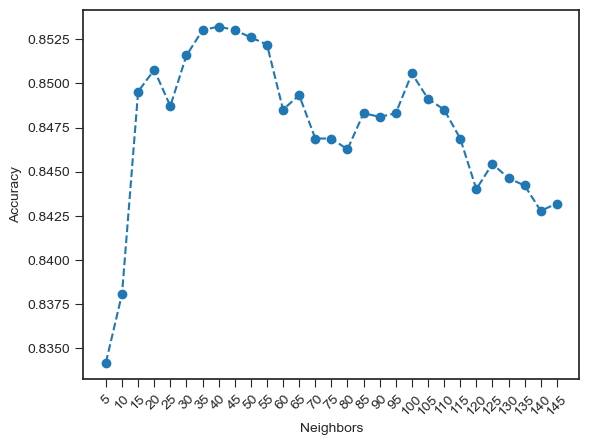

In [30]:
plt.plot(k_list, scores, "--")
plt.scatter(k_list, scores)
plt.ylabel("Accuracy")
plt.xlabel("Neighbors")
plt.xticks(k_list)
plt.xticks(rotation = 45)
plt.show()

In [31]:
print(f"The best accuracy: {np.round(max(scores) * 100, 2)} for {k_list[scores.index(max(scores))]} neighbors.")

The best accuracy: 85.32 for 40 neighbors.


## DecisionTree

In [32]:
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_train, y_train)
y_pred = model_DTC.predict(X_test)
print("Accuracy: ", np.round(accuracy_score(y_test, y_pred) * 100, 2))

Accuracy:  82.21


In [104]:
criterion_list = ["gini", "entropy"]
max_depth_list =  range(2, 15)
result = pd.DataFrame(columns = criterion_list, index = max_depth_list)

for i in range(len(criterion_list)):
    for j in range(len(max_depth_list)):
        model_DTC = DecisionTreeClassifier(criterion = criterion_list[i], max_depth = max_depth_list[j])
        model_DTC.fit(X_train, y_train)
        y_pred = model_DTC.predict(X_test)
        accuracy = np.round(accuracy_score(y_test, y_pred) * 100, 2)
        result[criterion_list[i]][max_depth_list[j]] = accuracy

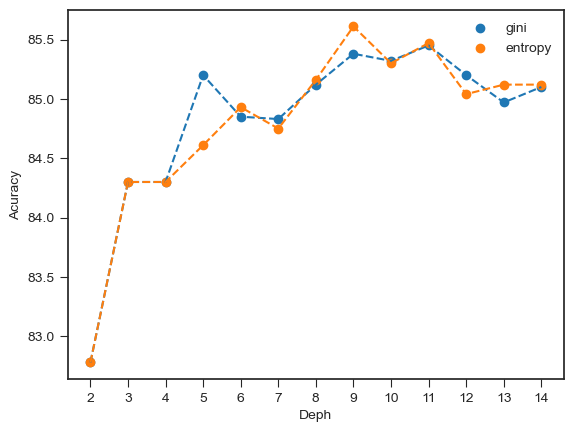

In [105]:
plt.scatter(result.index, result.gini)
plt.scatter(result.index, result.entropy)
plt.legend(["gini", 'entropy'])
plt.plot(result, "--")
plt.ylabel("Acuracy")
plt.xlabel("Deph")
plt.xticks(max_depth_list)
plt.show()

In [106]:
print(f"The best accuracy: {np.round(max(result['gini']), 2)} for gini criterion and deph = {result[result.gini == max(result['gini'])].index[0]}.")
print(f"The best accuracy: {np.round(max(result['entropy']), 2)} for entropy criterion and deph = {result[result.entropy == max(result['entropy'])].index[0]}.")

The best accuracy: 85.45 for gini criterion and deph = 11.
The best accuracy: 85.61 for entropy criterion and deph = 9.


## Bagging

In [53]:
from sklearn.ensemble import BaggingClassifier

In [54]:
model_b = BaggingClassifier(DecisionTreeClassifier())
model_b.fit(X_train, y_train)
y_pred = model_b.predict(X_test)

print("Accuracy: ", np.round(accuracy_score(y_test, y_pred) * 100, 2))

Accuracy:  84.34


### Using Optuna to optimize hyperparameters

In [65]:
def objective(trial):
    
    optuna = BaggingClassifier(DecisionTreeClassifier(max_depth = trial.suggest_int('max_depth', 2, 6), 
                                                            criterion = 'entropy'),
                                      n_estimators = trial.suggest_int('n_estimators', 50, 150),
                                      max_features = trial.suggest_categorical("max_features", [0.5, 0.6, 0.7, 0.8, 0.9, 1]),
                                      max_samples = trial.suggest_categorical("max_samples", [0.5, 0.6, 0.7, 0.8, 0.9, 1])
                                                                               )
    optuna.fit(X_train, y_train)
    y_pred = optuna.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction = 'maximize')

study.optimize(objective, n_trials=200)

[I 2023-08-01 12:02:37,699] A new study created in memory with name: no-name-42c4acd5-eb14-4ad2-977b-3cfc885e0fd3
[I 2023-08-01 12:02:39,923] Trial 0 finished with value: 0.8431934493346981 and parameters: {'max_depth': 2, 'n_estimators': 130, 'max_features': 0.7, 'max_samples': 0.9}. Best is trial 0 with value: 0.8431934493346981.
[I 2023-08-01 12:02:41,345] Trial 1 finished with value: 0.8470829068577277 and parameters: {'max_depth': 4, 'n_estimators': 65, 'max_features': 0.7, 'max_samples': 0.6}. Best is trial 1 with value: 0.8470829068577277.
[I 2023-08-01 12:02:42,698] Trial 2 finished with value: 0.7570112589559878 and parameters: {'max_depth': 4, 'n_estimators': 145, 'max_features': 0.8, 'max_samples': 1}. Best is trial 1 with value: 0.8470829068577277.
[I 2023-08-01 12:02:43,126] Trial 3 finished with value: 0.7570112589559878 and parameters: {'max_depth': 3, 'n_estimators': 91, 'max_features': 1, 'max_samples': 0.7}. Best is trial 1 with value: 0.8470829068577277.
[I 2023-08-0

[I 2023-08-01 12:04:19,831] Trial 37 finished with value: 0.7570112589559878 and parameters: {'max_depth': 5, 'n_estimators': 94, 'max_features': 1, 'max_samples': 1}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:04:24,196] Trial 38 finished with value: 0.8431934493346981 and parameters: {'max_depth': 4, 'n_estimators': 139, 'max_features': 0.9, 'max_samples': 0.9}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:04:26,298] Trial 39 finished with value: 0.8429887410440123 and parameters: {'max_depth': 3, 'n_estimators': 97, 'max_features': 0.8, 'max_samples': 0.7}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:04:29,054] Trial 40 finished with value: 0.8519959058341863 and parameters: {'max_depth': 5, 'n_estimators': 113, 'max_features': 0.6, 'max_samples': 0.9}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:04:31,445] Trial 41 finished with value: 0.8519959058341863 and parameters: {'max_depth': 5, 'n_estim

[I 2023-08-01 12:06:31,581] Trial 75 finished with value: 0.8530194472876151 and parameters: {'max_depth': 5, 'n_estimators': 101, 'max_features': 0.8, 'max_samples': 0.7}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:06:32,698] Trial 76 finished with value: 0.7570112589559878 and parameters: {'max_depth': 4, 'n_estimators': 136, 'max_features': 0.6, 'max_samples': 1}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:06:37,602] Trial 77 finished with value: 0.8524053224155578 and parameters: {'max_depth': 5, 'n_estimators': 140, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:06:43,159] Trial 78 finished with value: 0.8485158648925282 and parameters: {'max_depth': 6, 'n_estimators': 148, 'max_features': 0.8, 'max_samples': 0.9}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:06:46,018] Trial 79 finished with value: 0.8446264073694985 and parameters: {'max_depth': 4, 'n_e

[I 2023-08-01 12:08:27,619] Trial 112 finished with value: 0.8536335721596725 and parameters: {'max_depth': 5, 'n_estimators': 101, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:08:30,846] Trial 113 finished with value: 0.8507676560900717 and parameters: {'max_depth': 5, 'n_estimators': 100, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:08:34,143] Trial 114 finished with value: 0.8517911975435005 and parameters: {'max_depth': 5, 'n_estimators': 101, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:08:37,082] Trial 115 finished with value: 0.8532241555783009 and parameters: {'max_depth': 5, 'n_estimators': 93, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:08:39,870] Trial 116 finished with value: 0.8519959058341863 and parameters: {'max_depth': 5

[I 2023-08-01 12:09:55,508] Trial 149 finished with value: 0.8528147389969294 and parameters: {'max_depth': 5, 'n_estimators': 72, 'max_features': 0.8, 'max_samples': 0.7}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:09:58,660] Trial 150 finished with value: 0.8528147389969294 and parameters: {'max_depth': 5, 'n_estimators': 102, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:10:00,967] Trial 151 finished with value: 0.8528147389969294 and parameters: {'max_depth': 5, 'n_estimators': 74, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:10:03,673] Trial 152 finished with value: 0.8526100307062436 and parameters: {'max_depth': 5, 'n_estimators': 86, 'max_features': 0.8, 'max_samples': 0.8}. Best is trial 28 with value: 0.8544524053224155.
[I 2023-08-01 12:10:06,141] Trial 153 finished with value: 0.8511770726714432 and parameters: {'max_depth': 5, 

[I 2023-08-01 12:11:37,555] Trial 186 finished with value: 0.8528147389969294 and parameters: {'max_depth': 5, 'n_estimators': 115, 'max_features': 0.6, 'max_samples': 0.6}. Best is trial 183 with value: 0.8550665301944729.
[I 2023-08-01 12:11:40,396] Trial 187 finished with value: 0.8532241555783009 and parameters: {'max_depth': 5, 'n_estimators': 111, 'max_features': 0.6, 'max_samples': 0.6}. Best is trial 183 with value: 0.8550665301944729.
[I 2023-08-01 12:11:42,650] Trial 188 finished with value: 0.8474923234390993 and parameters: {'max_depth': 5, 'n_estimators': 106, 'max_features': 0.6, 'max_samples': 0.6}. Best is trial 183 with value: 0.8550665301944729.
[I 2023-08-01 12:11:44,049] Trial 189 finished with value: 0.8489252814738997 and parameters: {'max_depth': 5, 'n_estimators': 66, 'max_features': 0.6, 'max_samples': 0.6}. Best is trial 183 with value: 0.8550665301944729.
[I 2023-08-01 12:11:44,557] Trial 190 finished with value: 0.7570112589559878 and parameters: {'max_depth

In [70]:
optuna.visualization.plot_slice(study)

In [72]:
optuna.visualization.plot_optimization_history(study)

In [75]:
print('Best trial:')
trial = study.best_trial

print('Value: {}'.format(np.round(trial.value * 100, 2)))
print('Params: ')

for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

Best trial:
Value: 85.51
Params: 
max_depth: 5
n_estimators: 114
max_features: 0.6
max_samples: 0.6


## Boosting - AdaBoost

In [77]:
model_AB = AdaBoostClassifier(DecisionTreeClassifier())
model_AB.fit(X_train, y_train)
y_pred = model_AB.predict(X_test)
print("Accuracy: ", np.round(accuracy_score(y_test, y_pred) * 100, 2))

Accuracy:  82.87


### Using Optuna to optimize hyperparameters

In [80]:
def objective(trial):
    
    optuna_AB = AdaBoostClassifier(DecisionTreeClassifier(max_depth = trial.suggest_int('max_depth', 2, 6), criterion = 'entropy'),
                                      n_estimators = trial.suggest_categorical('n_estimators', [20, 30, 50, 70, 100, 150, 200]),
                                      learning_rate = trial.suggest_categorical("learnig_rate", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
    optuna_AB.fit(X_train, y_train)
    y_pred = optuna_AB.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study_AB = optuna.create_study(direction = 'maximize')

study_AB.optimize(objective, n_trials=200)

[I 2023-08-01 12:25:47,904] A new study created in memory with name: no-name-86396f30-3ba6-44d2-a876-94ea7cae4181
[I 2023-08-01 12:26:01,749] Trial 0 finished with value: 0.8335721596724668 and parameters: {'max_depth': 6, 'n_estimators': 200, 'learnig_rate': 0.7}. Best is trial 0 with value: 0.8335721596724668.
[I 2023-08-01 12:26:03,369] Trial 1 finished with value: 0.8591606960081883 and parameters: {'max_depth': 2, 'n_estimators': 50, 'learnig_rate': 0.6}. Best is trial 1 with value: 0.8591606960081883.
[I 2023-08-01 12:26:04,564] Trial 2 finished with value: 0.8567041965199591 and parameters: {'max_depth': 5, 'n_estimators': 20, 'learnig_rate': 0.5}. Best is trial 1 with value: 0.8591606960081883.
[I 2023-08-01 12:26:14,495] Trial 3 finished with value: 0.8532241555783009 and parameters: {'max_depth': 4, 'n_estimators': 200, 'learnig_rate': 0.2}. Best is trial 1 with value: 0.8591606960081883.
[I 2023-08-01 12:26:15,916] Trial 4 finished with value: 0.8575230296827021 and paramete

[I 2023-08-01 12:28:53,551] Trial 41 finished with value: 0.8616171954964176 and parameters: {'max_depth': 3, 'n_estimators': 50, 'learnig_rate': 0.3}. Best is trial 22 with value: 0.8626407369498464.
[I 2023-08-01 12:28:55,637] Trial 42 finished with value: 0.8616171954964176 and parameters: {'max_depth': 3, 'n_estimators': 50, 'learnig_rate': 0.3}. Best is trial 22 with value: 0.8626407369498464.
[I 2023-08-01 12:28:58,208] Trial 43 finished with value: 0.8593654042988741 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.5}. Best is trial 22 with value: 0.8626407369498464.
[I 2023-08-01 12:29:00,341] Trial 44 finished with value: 0.8599795291709315 and parameters: {'max_depth': 3, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 22 with value: 0.8626407369498464.
[I 2023-08-01 12:29:03,571] Trial 45 finished with value: 0.8544524053224155 and parameters: {'max_depth': 2, 'n_estimators': 100, 'learnig_rate': 1}. Best is trial 22 with value: 0.86264073694984

[I 2023-08-01 12:30:32,624] Trial 82 finished with value: 0.8620266120777892 and parameters: {'max_depth': 3, 'n_estimators': 30, 'learnig_rate': 0.4}. Best is trial 22 with value: 0.8626407369498464.
[I 2023-08-01 12:30:33,845] Trial 83 finished with value: 0.8620266120777892 and parameters: {'max_depth': 3, 'n_estimators': 30, 'learnig_rate': 0.4}. Best is trial 22 with value: 0.8626407369498464.
[I 2023-08-01 12:30:35,111] Trial 84 finished with value: 0.8571136131013306 and parameters: {'max_depth': 3, 'n_estimators': 30, 'learnig_rate': 0.3}. Best is trial 22 with value: 0.8626407369498464.
[I 2023-08-01 12:30:38,026] Trial 85 finished with value: 0.8628454452405322 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:30:40,958] Trial 86 finished with value: 0.8628454452405322 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405

[I 2023-08-01 12:32:23,242] Trial 123 finished with value: 0.8628454452405322 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:32:26,118] Trial 124 finished with value: 0.8628454452405322 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:32:32,065] Trial 125 finished with value: 0.8524053224155578 and parameters: {'max_depth': 4, 'n_estimators': 100, 'learnig_rate': 0.7}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:32:42,132] Trial 126 finished with value: 0.8560900716479017 and parameters: {'max_depth': 5, 'n_estimators': 150, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:32:44,801] Trial 127 finished with value: 0.8628454452405322 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.862845

[I 2023-08-01 12:34:41,427] Trial 164 finished with value: 0.8626407369498464 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:34:44,091] Trial 165 finished with value: 0.8626407369498464 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:34:46,790] Trial 166 finished with value: 0.8626407369498464 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:34:49,431] Trial 167 finished with value: 0.8626407369498464 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.8628454452405322.
[I 2023-08-01 12:34:52,177] Trial 168 finished with value: 0.8626407369498464 and parameters: {'max_depth': 4, 'n_estimators': 50, 'learnig_rate': 0.2}. Best is trial 85 with value: 0.86284544

In [81]:
optuna.visualization.plot_slice(study_AB)

In [82]:
optuna.visualization.plot_optimization_history(study_AB)

In [83]:
print('Best trial:')
trial_AB = study_AB.best_trial

print('Value: {}'.format(np.round(trial_AB.value * 100, 2)))
print('Params: ')

for key, value in trial_AB.params.items():
    print('{}: {}'.format(key, value))

Best trial:
Value: 86.28
Params: 
max_depth: 4
n_estimators: 50
learnig_rate: 0.2


## XGBoost

In [84]:
from xgboost.sklearn import XGBClassifier

In [85]:
model_XGB = XGBClassifier()
model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_test)
accuracy_score(y_test, y_pred)

0.8636642784032753

### Using Optuna to optimize hyperparameters

In [86]:
def objective(trial):
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4),
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 75, 100, 150]),
        'gamma': trial.suggest_float('gamma', 0.4, 1),
        'lambda': trial.suggest_float('lambda', 0.4, 1),
        'subsample': trial.suggest_categorical('subsample', [0.9, 1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.5, 0.6, 0.7]),
    }
   
    optuna_XGB = XGBClassifier(**params)
    optuna_XGB.fit(X_train, y_train)
    y_pred = optuna_XGB.predict(X_test)
    accuracy_XGB = accuracy_score(y_test, y_pred)
    
    return accuracy_XGB

study_XGB = optuna.create_study(direction='maximize')
study_XGB.optimize(objective, n_trials=400)

[I 2023-08-01 12:45:11,147] A new study created in memory with name: no-name-06291aec-9b86-40fe-aa02-9a55cf41264d
[I 2023-08-01 12:45:11,654] Trial 0 finished with value: 0.8628454452405322 and parameters: {'max_depth': 3, 'learning_rate': 0.2535068238099461, 'n_estimators': 50, 'gamma': 0.7380357365392061, 'lambda': 0.8004027996607139, 'subsample': 1.0, 'colsample_bynode': 0.6}. Best is trial 0 with value: 0.8628454452405322.
[I 2023-08-01 12:45:13,392] Trial 1 finished with value: 0.8636642784032753 and parameters: {'max_depth': 3, 'learning_rate': 0.2558920952063417, 'n_estimators': 150, 'gamma': 0.5483884933187037, 'lambda': 0.9706947921906096, 'subsample': 0.9, 'colsample_bynode': 0.7}. Best is trial 1 with value: 0.8636642784032753.
[I 2023-08-01 12:45:14,859] Trial 2 finished with value: 0.8640736949846469 and parameters: {'max_depth': 8, 'learning_rate': 0.09070491393335187, 'n_estimators': 50, 'gamma': 0.6556961352888392, 'lambda': 0.8059712841827072, 'subsample': 0.9, 'colsam

[I 2023-08-01 12:45:45,268] Trial 26 finished with value: 0.8648925281473899 and parameters: {'max_depth': 7, 'learning_rate': 0.11729919731387924, 'n_estimators': 50, 'gamma': 0.6571529191260943, 'lambda': 0.6423472681317559, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 17 with value: 0.8667349027635619.
[I 2023-08-01 12:45:47,157] Trial 27 finished with value: 0.8628454452405322 and parameters: {'max_depth': 5, 'learning_rate': 0.19594819248598788, 'n_estimators': 150, 'gamma': 0.5987608350416991, 'lambda': 0.6905316051284852, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 17 with value: 0.8667349027635619.
[I 2023-08-01 12:45:48,338] Trial 28 finished with value: 0.8648925281473899 and parameters: {'max_depth': 6, 'learning_rate': 0.16026636153765597, 'n_estimators': 75, 'gamma': 0.6857354332291162, 'lambda': 0.5754252422475067, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 17 with value: 0.8667349027635619.
[I 2023-08-01 12:45:49,069] Trial 29 fi

[I 2023-08-01 12:46:17,990] Trial 52 finished with value: 0.8616171954964176 and parameters: {'max_depth': 4, 'learning_rate': 0.15042311293822097, 'n_estimators': 50, 'gamma': 0.7205698394456399, 'lambda': 0.7175914803449824, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 43 with value: 0.8679631525076765.
[I 2023-08-01 12:46:18,798] Trial 53 finished with value: 0.8655066530194473 and parameters: {'max_depth': 5, 'learning_rate': 0.20957952692035997, 'n_estimators': 50, 'gamma': 0.6684491476160851, 'lambda': 0.6820742470292342, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 43 with value: 0.8679631525076765.
[I 2023-08-01 12:46:20,835] Trial 54 finished with value: 0.8644831115660184 and parameters: {'max_depth': 5, 'learning_rate': 0.13077303681591235, 'n_estimators': 150, 'gamma': 0.6957516112118286, 'lambda': 0.764673456252501, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 43 with value: 0.8679631525076765.
[I 2023-08-01 12:46:22,011] Trial 55 fin

[I 2023-08-01 12:46:51,408] Trial 78 finished with value: 0.8640736949846469 and parameters: {'max_depth': 5, 'learning_rate': 0.16828663512776365, 'n_estimators': 100, 'gamma': 0.6887701581531142, 'lambda': 0.6783894312278221, 'subsample': 1.0, 'colsample_bynode': 0.7}. Best is trial 61 with value: 0.8685772773797339.
[I 2023-08-01 12:46:52,431] Trial 79 finished with value: 0.8661207778915047 and parameters: {'max_depth': 5, 'learning_rate': 0.12428891440197609, 'n_estimators': 75, 'gamma': 0.7614617646048444, 'lambda': 0.7915526515839787, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 61 with value: 0.8685772773797339.
[I 2023-08-01 12:46:53,792] Trial 80 finished with value: 0.8644831115660184 and parameters: {'max_depth': 7, 'learning_rate': 0.1435890365119733, 'n_estimators': 75, 'gamma': 0.6578128972040134, 'lambda': 0.7020271282330535, 'subsample': 1.0, 'colsample_bynode': 0.5}. Best is trial 61 with value: 0.8685772773797339.
[I 2023-08-01 12:46:54,643] Trial 81 fin

[I 2023-08-01 12:47:21,052] Trial 104 finished with value: 0.8663254861821904 and parameters: {'max_depth': 6, 'learning_rate': 0.1271690996338383, 'n_estimators': 50, 'gamma': 0.7830872699392945, 'lambda': 0.6696508478949961, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 85 with value: 0.8687819856704196.
[I 2023-08-01 12:47:22,019] Trial 105 finished with value: 0.8696008188331628 and parameters: {'max_depth': 6, 'learning_rate': 0.15074845568813788, 'n_estimators': 50, 'gamma': 0.7544541622707177, 'lambda': 0.7303652444458877, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 105 with value: 0.8696008188331628.
[I 2023-08-01 12:47:22,985] Trial 106 finished with value: 0.8685772773797339 and parameters: {'max_depth': 6, 'learning_rate': 0.1524047765665019, 'n_estimators': 50, 'gamma': 0.7934263888388747, 'lambda': 0.7280807003299733, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 105 with value: 0.8696008188331628.
[I 2023-08-01 12:47:24,030] Trial 107

[I 2023-08-01 12:47:49,952] Trial 130 finished with value: 0.8628454452405322 and parameters: {'max_depth': 7, 'learning_rate': 0.10395365863417476, 'n_estimators': 50, 'gamma': 0.8418207067919399, 'lambda': 0.7824645832763537, 'subsample': 0.9, 'colsample_bynode': 0.6}. Best is trial 116 with value: 0.87021494370522.
[I 2023-08-01 12:47:51,059] Trial 131 finished with value: 0.8669396110542477 and parameters: {'max_depth': 7, 'learning_rate': 0.13223788725120095, 'n_estimators': 50, 'gamma': 0.8152747481660749, 'lambda': 0.7373280749781199, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 116 with value: 0.87021494370522.
[I 2023-08-01 12:47:52,160] Trial 132 finished with value: 0.8696008188331628 and parameters: {'max_depth': 7, 'learning_rate': 0.12657470467315787, 'n_estimators': 50, 'gamma': 0.7913417357327334, 'lambda': 0.7145294790292497, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 116 with value: 0.87021494370522.
[I 2023-08-01 12:47:53,248] Trial 133 fi

[I 2023-08-01 12:48:21,840] Trial 156 finished with value: 0.8681678607983623 and parameters: {'max_depth': 6, 'learning_rate': 0.14118019095724837, 'n_estimators': 50, 'gamma': 0.7675735585044642, 'lambda': 0.7191780338187621, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:48:22,910] Trial 157 finished with value: 0.8671443193449335 and parameters: {'max_depth': 6, 'learning_rate': 0.15177209040686854, 'n_estimators': 50, 'gamma': 0.744485092700911, 'lambda': 0.764350114451018, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:48:24,050] Trial 158 finished with value: 0.8650972364380758 and parameters: {'max_depth': 6, 'learning_rate': 0.12349230953963289, 'n_estimators': 50, 'gamma': 0.7265926856058321, 'lambda': 0.7497503826396201, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:48:25,321] Trial 15

[I 2023-08-01 12:48:53,764] Trial 182 finished with value: 0.87021494370522 and parameters: {'max_depth': 7, 'learning_rate': 0.1564271343645339, 'n_estimators': 50, 'gamma': 0.8119336619499884, 'lambda': 0.7597729850191635, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:48:55,258] Trial 183 finished with value: 0.8698055271238485 and parameters: {'max_depth': 7, 'learning_rate': 0.1481545413576931, 'n_estimators': 50, 'gamma': 0.7689403083289366, 'lambda': 0.7441824104937528, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:48:56,712] Trial 184 finished with value: 0.8679631525076765 and parameters: {'max_depth': 7, 'learning_rate': 0.14477073675204014, 'n_estimators': 50, 'gamma': 0.7659611497446851, 'lambda': 0.7621075236682224, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:48:58,101] Trial 185 

[I 2023-08-01 12:49:31,286] Trial 208 finished with value: 0.8689866939611054 and parameters: {'max_depth': 7, 'learning_rate': 0.14876788348780468, 'n_estimators': 50, 'gamma': 0.6762141396617275, 'lambda': 0.7064737886110126, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:49:32,467] Trial 209 finished with value: 0.8691914022517911 and parameters: {'max_depth': 7, 'learning_rate': 0.14776238680538087, 'n_estimators': 50, 'gamma': 0.6818626701469053, 'lambda': 0.9990271734418998, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:49:33,670] Trial 210 finished with value: 0.8677584442169908 and parameters: {'max_depth': 7, 'learning_rate': 0.1487831430806804, 'n_estimators': 50, 'gamma': 0.6768089966188847, 'lambda': 0.8204514573895122, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:49:34,866] Trial 2

[I 2023-08-01 12:50:05,084] Trial 234 finished with value: 0.8671443193449335 and parameters: {'max_depth': 7, 'learning_rate': 0.11219483653339998, 'n_estimators': 50, 'gamma': 0.8333330272357996, 'lambda': 0.995189130055361, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:50:06,349] Trial 235 finished with value: 0.869396110542477 and parameters: {'max_depth': 7, 'learning_rate': 0.13697982443451853, 'n_estimators': 50, 'gamma': 0.8198040143873918, 'lambda': 0.9993504849110275, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:50:07,599] Trial 236 finished with value: 0.867553735926305 and parameters: {'max_depth': 7, 'learning_rate': 0.1361279320610108, 'n_estimators': 50, 'gamma': 0.7918510999003685, 'lambda': 0.9837660323538436, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:50:09,048] Trial 237 

[I 2023-08-01 12:50:42,329] Trial 260 finished with value: 0.8665301944728762 and parameters: {'max_depth': 7, 'learning_rate': 0.09642861252120143, 'n_estimators': 50, 'gamma': 0.70200148120457, 'lambda': 0.8885663617420199, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:50:43,517] Trial 261 finished with value: 0.8691914022517911 and parameters: {'max_depth': 7, 'learning_rate': 0.15861610044496915, 'n_estimators': 50, 'gamma': 0.6396826301078513, 'lambda': 0.8823614715755871, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:50:44,842] Trial 262 finished with value: 0.8659160696008188 and parameters: {'max_depth': 8, 'learning_rate': 0.21712213956704898, 'n_estimators': 50, 'gamma': 0.6359236601679261, 'lambda': 0.8771548725036507, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:50:46,174] Trial 26

[I 2023-08-01 12:51:16,213] Trial 286 finished with value: 0.8665301944728762 and parameters: {'max_depth': 7, 'learning_rate': 0.20832031609192117, 'n_estimators': 50, 'gamma': 0.988978598142876, 'lambda': 0.8310387727487388, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:51:17,713] Trial 287 finished with value: 0.8638689866939611 and parameters: {'max_depth': 8, 'learning_rate': 0.1898285639810418, 'n_estimators': 50, 'gamma': 0.8693153889826623, 'lambda': 0.9054146545096106, 'subsample': 0.9, 'colsample_bynode': 0.6}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:51:18,919] Trial 288 finished with value: 0.867553735926305 and parameters: {'max_depth': 7, 'learning_rate': 0.1601574886522934, 'n_estimators': 50, 'gamma': 0.8455207006950588, 'lambda': 0.8497227598297029, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:51:20,198] Trial 289 

[I 2023-08-01 12:51:53,065] Trial 312 finished with value: 0.8687819856704196 and parameters: {'max_depth': 7, 'learning_rate': 0.12271093775010966, 'n_estimators': 50, 'gamma': 0.7213968776134807, 'lambda': 0.47702728542329664, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:51:54,241] Trial 313 finished with value: 0.8665301944728762 and parameters: {'max_depth': 7, 'learning_rate': 0.19353049091857905, 'n_estimators': 50, 'gamma': 0.9120115856595432, 'lambda': 0.6009178604512014, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:51:55,454] Trial 314 finished with value: 0.869396110542477 and parameters: {'max_depth': 7, 'learning_rate': 0.16171412057073634, 'n_estimators': 50, 'gamma': 0.6945620363226054, 'lambda': 0.8768674476329639, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:51:56,621] Trial 

[I 2023-08-01 12:52:31,393] Trial 338 finished with value: 0.8556806550665302 and parameters: {'max_depth': 3, 'learning_rate': 0.13280691598605845, 'n_estimators': 50, 'gamma': 0.729510362356892, 'lambda': 0.8620050304664298, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:52:32,063] Trial 339 finished with value: 0.8554759467758444 and parameters: {'max_depth': 2, 'learning_rate': 0.15352046294593164, 'n_estimators': 50, 'gamma': 0.9095316215948237, 'lambda': 0.7214502013757066, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:52:33,146] Trial 340 finished with value: 0.8640736949846469 and parameters: {'max_depth': 6, 'learning_rate': 0.09313923683111955, 'n_estimators': 50, 'gamma': 0.8156562758640405, 'lambda': 0.8889262940877827, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:52:36,500] Trial 3

[I 2023-08-01 12:53:06,018] Trial 364 finished with value: 0.8636642784032753 and parameters: {'max_depth': 7, 'learning_rate': 0.15064276365886808, 'n_estimators': 150, 'gamma': 0.7623111893917434, 'lambda': 0.9420891766858099, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:53:07,218] Trial 365 finished with value: 0.8689866939611054 and parameters: {'max_depth': 7, 'learning_rate': 0.13683950465745243, 'n_estimators': 50, 'gamma': 0.6938122774393837, 'lambda': 0.9613750612584364, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:53:08,331] Trial 366 finished with value: 0.8681678607983623 and parameters: {'max_depth': 7, 'learning_rate': 0.1608835257411262, 'n_estimators': 50, 'gamma': 0.7465371306920916, 'lambda': 0.6918290178551352, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:53:09,378] Trial 

[I 2023-08-01 12:53:38,817] Trial 390 finished with value: 0.8653019447287615 and parameters: {'max_depth': 6, 'learning_rate': 0.11310713203556105, 'n_estimators': 50, 'gamma': 0.9740069244246102, 'lambda': 0.7855263625586747, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:53:39,880] Trial 391 finished with value: 0.8683725690890481 and parameters: {'max_depth': 6, 'learning_rate': 0.23857531560760667, 'n_estimators': 50, 'gamma': 0.8033331109351599, 'lambda': 0.8383381038585134, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:53:42,018] Trial 392 finished with value: 0.8642784032753327 and parameters: {'max_depth': 6, 'learning_rate': 0.1980548167007779, 'n_estimators': 100, 'gamma': 0.7086385105550702, 'lambda': 0.7670112703418749, 'subsample': 0.9, 'colsample_bynode': 0.5}. Best is trial 150 with value: 0.8706243602865916.
[I 2023-08-01 12:53:43,229] Trial 

In [90]:
print('Best trial:')
trial_XGB = study_XGB.best_trial

print('Value: {}'.format(np.round(trial_XGB.value * 100, 2)))
print('Params: ')

for key, value in trial_XGB.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
Value: 87.06
Params: 
    max_depth: 6
    learning_rate: 0.17106760620654307
    n_estimators: 50
    gamma: 0.7464069119766288
    lambda: 0.7554762897830876
    subsample: 0.9
    colsample_bynode: 0.5


In [91]:
study_XGB.trials_dataframe().sort_values("value", ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bynode,params_gamma,params_lambda,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,state
150,150,0.870624,2023-08-01 12:48:13.834513,2023-08-01 12:48:14.861765,0 days 00:00:01.027252,0.5,0.746407,0.755476,0.171068,6,50,0.9,COMPLETE
214,214,0.870215,2023-08-01 12:49:38.023921,2023-08-01 12:49:39.469195,0 days 00:00:01.445274,0.5,0.692559,0.943284,0.133740,7,50,0.9,COMPLETE
271,271,0.870215,2023-08-01 12:50:56.135933,2023-08-01 12:50:57.307428,0 days 00:00:01.171495,0.5,0.999416,0.877369,0.117051,7,50,0.9,COMPLETE
116,116,0.870215,2023-08-01 12:47:31.802671,2023-08-01 12:47:32.877031,0 days 00:00:01.074360,0.5,0.777103,0.743252,0.132253,7,50,0.9,COMPLETE
182,182,0.870215,2023-08-01 12:48:51.889008,2023-08-01 12:48:53.764015,0 days 00:00:01.875007,0.5,0.811934,0.759773,0.156427,7,50,0.9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,147,0.855681,2023-08-01 12:48:10.731618,2023-08-01 12:48:11.434154,0 days 00:00:00.702536,0.5,0.817379,0.744180,0.129268,3,50,0.9,COMPLETE
10,10,0.855681,2023-08-01 12:45:24.125431,2023-08-01 12:45:27.545442,0 days 00:00:03.420011,0.7,0.989539,0.855099,0.017950,6,150,1.0,COMPLETE
339,339,0.855476,2023-08-01 12:52:31.393744,2023-08-01 12:52:32.063768,0 days 00:00:00.670024,0.5,0.909532,0.721450,0.153520,2,50,0.9,COMPLETE
7,7,0.855067,2023-08-01 12:45:19.719201,2023-08-01 12:45:21.815327,0 days 00:00:02.096126,0.5,0.771197,0.973170,0.315440,8,100,1.0,COMPLETE


In [93]:
optuna.visualization.plot_slice(study_XGB)

In [95]:
optuna.visualization.plot_param_importances(study_XGB)

# Summary

In [122]:
x = {"model" : ["KNN", "DecisionTree", "Bagging", "AdaBoost", "XGBoost"],
     "scores" : [np.round(max(scores) * 100, 2), np.round(max(result['entropy']), 2), 
                   np.round(trial.value * 100, 2), np.round(trial_AB.value * 100, 2), np.round(trial_XGB.value * 100, 2)]
    }

the_best_scores = pd.DataFrame(x)
the_best_scores

,model,scores
0,KNN,85.32
1,DecisionTree,85.61
2,Bagging,85.51
3,AdaBoost,86.28
4,XGBoost,87.06
